# Approach 2: Fine-tune DistilBERT for 3-Class Sentiment Classification

**End-to-end**: Raw YouTube comments → DistilBERT tokenizer → Fine-tuned DistilBERT → `positive / neutral / negative`

Unlike Approach 1 (SVM on embeddings+VADER), here the model **learns its own representations** optimized specifically for sentiment.

In [1]:
import numpy as np
import pandas as pd
import json
import os
import re
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

# Paths
RAW_DATA_PATH = '/home/ram/sentiment_mlops/data/raw/YoutubeCommentsDataSet.csv'
MODEL_PATH = '/home/ram/sentiment_mlops/models/distilbert_sentiment/'
os.makedirs(MODEL_PATH, exist_ok=True)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Device: {device}')
if device == 'cuda':
    print(f'GPU: {torch.cuda.get_device_name(0)}')
else:
    print('No GPU found — training will be slower but will still work.')

Device: cuda
GPU: NVIDIA GeForce RTX 2060


In [2]:
## 1. Load & Prepare Data
df = pd.read_csv(RAW_DATA_PATH)
df['Comment'] = df['Comment'].fillna('').astype(str)

# Basic text cleaning (lighter than Approach 1 — DistilBERT handles punctuation well)
def clean_text(text):
    text = re.sub(r'http\S+|www\.\S+', '', text)  # Remove URLs
    text = re.sub(r'\s+', ' ', text).strip()         # Collapse whitespace
    return text

df['Comment'] = df['Comment'].apply(clean_text)
df = df[df['Sentiment'].isin(['positive', 'negative', 'neutral'])]

# Encode labels
label_map = {'positive': 0, 'neutral': 1, 'negative': 2}
inv_label_map = {v: k for k, v in label_map.items()}
df['label'] = df['Sentiment'].map(label_map)

print(f'Total samples: {len(df)}')
print(f'Class distribution:\n{df["Sentiment"].value_counts()}')

# Stratified train/val/test split (80/10/10)
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['label'])

print(f'\nTrain: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}')

Total samples: 18408
Class distribution:
Sentiment
positive    11432
neutral      4638
negative     2338
Name: count, dtype: int64

Train: 14726, Val: 1841, Test: 1841


In [3]:
## 2. Tokenize with DistilBERT Tokenizer
from transformers import DistilBertTokenizerFast

MODEL_NAME = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizerFast.from_pretrained(MODEL_NAME)

# Check max comment length to set max_length
token_lengths = [len(tokenizer.encode(t)) for t in train_df['Comment'].tolist()[:2000]]
print(f'Token length stats (sample of 2000):')
print(f'  Mean: {np.mean(token_lengths):.0f}, Max: {np.max(token_lengths)}, 95th pct: {np.percentile(token_lengths, 95):.0f}')

MAX_LENGTH = min(int(np.percentile(token_lengths, 95)) + 10, 256)
print(f'\nUsing MAX_LENGTH = {MAX_LENGTH} (covers 95%+ of comments, truncates the rest)')

/home/ram/sentiment_mlops/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Token indices sequence length is longer than the specified maximum sequence length for this model (1004 > 512). Running this sequence through the model will result in indexing errors


Token length stats (sample of 2000):
  Mean: 39, Max: 1004, 95th pct: 111

Using MAX_LENGTH = 121 (covers 95%+ of comments, truncates the rest)


In [4]:
## 3. Create HuggingFace Dataset
from datasets import Dataset

def make_dataset(dataframe):
    ds = Dataset.from_pandas(dataframe[['Comment', 'label']].reset_index(drop=True))
    ds = ds.rename_column('Comment', 'text')
    return ds

train_ds = make_dataset(train_df)
val_ds   = make_dataset(val_df)
test_ds  = make_dataset(test_df)

# Tokenize all splits
def tokenize_fn(batch):
    return tokenizer(batch['text'], padding='max_length', truncation=True, max_length=MAX_LENGTH)

train_ds = train_ds.map(tokenize_fn, batched=True, batch_size=256)
val_ds   = val_ds.map(tokenize_fn, batched=True, batch_size=256)
test_ds  = test_ds.map(tokenize_fn, batched=True, batch_size=256)

# Set format for PyTorch
train_ds.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
val_ds.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
test_ds.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

print(f'Tokenized datasets:')
print(f'  Train: {len(train_ds)}, Val: {len(val_ds)}, Test: {len(test_ds)}')
print(f'  Columns: {train_ds.column_names}')

Map: 100%|██████████| 1841/1841 [00:00<00:00, 10175.27 examples/s]

Tokenized datasets:
  Train: 14726, Val: 1841, Test: 1841
  Columns: ['text', 'label', 'input_ids', 'attention_mask']


In [5]:
## 4. Load DistilBERT for Sequence Classification
from transformers import DistilBertForSequenceClassification

model = DistilBertForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=3,
    id2label=inv_label_map,
    label2id=label_map
)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Total parameters:     {total_params:,}')
print(f'Trainable parameters: {trainable_params:,}')
print(f'Model architecture: DistilBERT + 3-class classification head')

Loading weights: 100%|██████████| 100/100 [00:00<00:00, 353.00it/s, Materializing param=distilbert.transformer.layer.5.sa_layer_norm.weight]   
DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_transform.bias    | UNEXPECTED | 
vocab_layer_norm.weight | UNEXPECTED | 
vocab_transform.weight  | UNEXPECTED | 
vocab_projector.bias    | UNEXPECTED | 
vocab_layer_norm.bias   | UNEXPECTED | 
classifier.bias         | MISSING    | 
pre_classifier.bias     | MISSING    | 
classifier.weight       | MISSING    | 
pre_classifier.weight   | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Total parameters:     66,955,779
Trainable parameters: 66,955,779
Model architecture: DistilBERT + 3-class classification head


In [6]:
## 5. Training Configuration
from transformers import TrainingArguments, Trainer

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    return {'accuracy': acc}

training_args = TrainingArguments(
    output_dir=MODEL_PATH,
    num_train_epochs=3,
    per_device_train_batch_size=32 if device == 'cuda' else 16,
    per_device_eval_batch_size=64 if device == 'cuda' else 32,
    learning_rate=2e-5,
    weight_decay=0.01,
    warmup_ratio=0.1,
    eval_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    logging_steps=50,
    fp16=torch.cuda.is_available(),  # Mixed precision if GPU available
    report_to='none',  # Disable wandb/mlflow
    seed=42,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    compute_metrics=compute_metrics,
)

print('Training config:')
print(f'  Epochs: {training_args.num_train_epochs}')
print(f'  Batch size: {training_args.per_device_train_batch_size}')
print(f'  Learning rate: {training_args.learning_rate}')
print(f'  FP16: {training_args.fp16}')
print(f'  Steps per epoch: ~{len(train_ds) // training_args.per_device_train_batch_size}')

warmup_ratio is deprecated and will be removed in v5.2. Use `warmup_steps` instead.


Training config:
  Epochs: 3
  Batch size: 32
  Learning rate: 2e-05
  FP16: True
  Steps per epoch: ~460


In [7]:
## 6. Train!
print('Fine-tuning DistilBERT...')
print('=' * 60)

train_result = trainer.train()

print('\n' + '=' * 60)
print(f'Training complete!')
print(f'Total training time: {train_result.metrics["train_runtime"]:.0f}s')
print(f'Final train loss: {train_result.metrics["train_loss"]:.4f}')

Fine-tuning DistilBERT...


Epoch,Training Loss,Validation Loss,Accuracy
1,0.404017,0.397717,0.826181
2,0.279986,0.415254,0.838675
3,0.203406,0.404990,0.848452


Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]
There were missing keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.weight', 'distilbert.embeddings.LayerNorm.bias'].
There were unexpected keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.beta', 'distilbert.embeddings.LayerNorm.gamma'].



Training complete!
Total training time: 180s
Final train loss: 0.3502


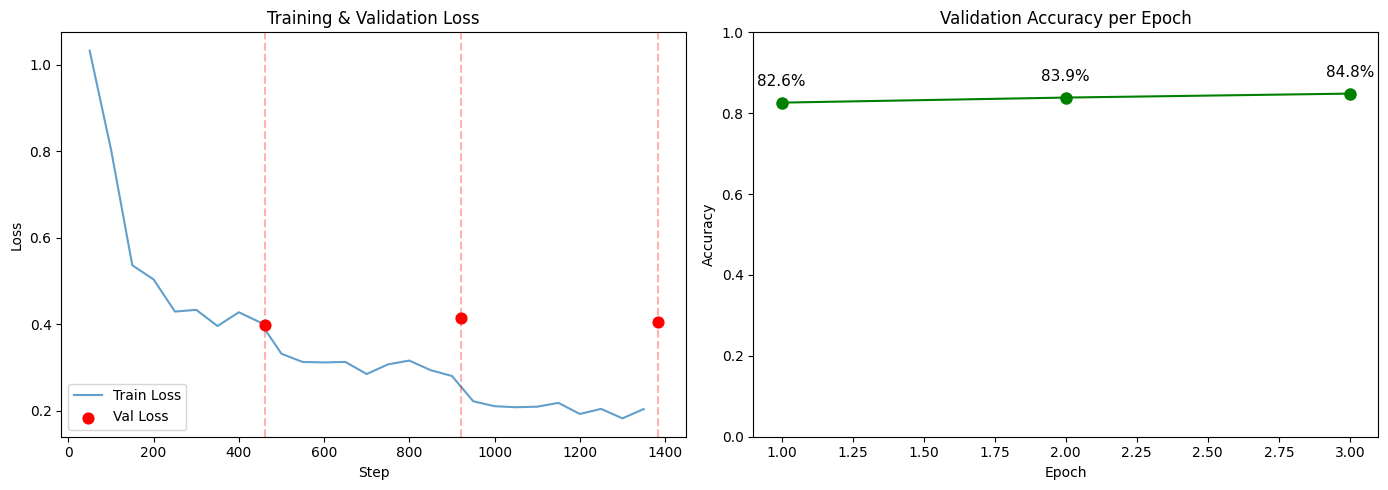

In [8]:
## 7. Training History
log_history = trainer.state.log_history

# Extract train loss and eval metrics per epoch
train_losses = [h['loss'] for h in log_history if 'loss' in h and 'eval_loss' not in h]
train_steps  = [h['step'] for h in log_history if 'loss' in h and 'eval_loss' not in h]
eval_entries = [h for h in log_history if 'eval_accuracy' in h]
eval_epochs  = [h['epoch'] for h in eval_entries]
eval_accs    = [h['eval_accuracy'] for h in eval_entries]
eval_losses  = [h['eval_loss'] for h in eval_entries]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training loss curve
axes[0].plot(train_steps, train_losses, alpha=0.7, label='Train Loss')
for i, e in enumerate(eval_entries):
    axes[0].axvline(x=e['step'], color='red', linestyle='--', alpha=0.3)
    axes[0].scatter(e['step'], e['eval_loss'], color='red', s=60, zorder=5,
                    label='Val Loss' if i == 0 else '')
axes[0].set_xlabel('Step')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training & Validation Loss')
axes[0].legend()

# Validation accuracy per epoch
axes[1].plot(eval_epochs, eval_accs, 'o-', color='green', markersize=8)
for ep, ac in zip(eval_epochs, eval_accs):
    axes[1].annotate(f'{ac:.1%}', (ep, ac), textcoords='offset points',
                     xytext=(0, 12), ha='center', fontsize=11)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Validation Accuracy per Epoch')
axes[1].set_ylim(0, 1)

plt.tight_layout()
plt.show()

In [9]:
## 8. Evaluate on Test Set
test_results = trainer.predict(test_ds)
y_pred = np.argmax(test_results.predictions, axis=-1)
y_true = test_results.label_ids

acc = accuracy_score(y_true, y_pred)
print(f'\n{"="*50}')
print(f'  TEST ACCURACY: {acc:.4f} ({acc*100:.1f}%)')
print(f'{"="*50}\n')

target_names = [inv_label_map[i] for i in sorted(inv_label_map.keys())]
print(classification_report(y_true, y_pred, target_names=target_names))


  TEST ACCURACY: 0.8555 (85.6%)

              precision    recall  f1-score   support

    positive       0.91      0.92      0.92      1143
     neutral       0.75      0.72      0.73       464
    negative       0.79      0.78      0.79       234

    accuracy                           0.86      1841
   macro avg       0.82      0.81      0.81      1841
weighted avg       0.85      0.86      0.85      1841



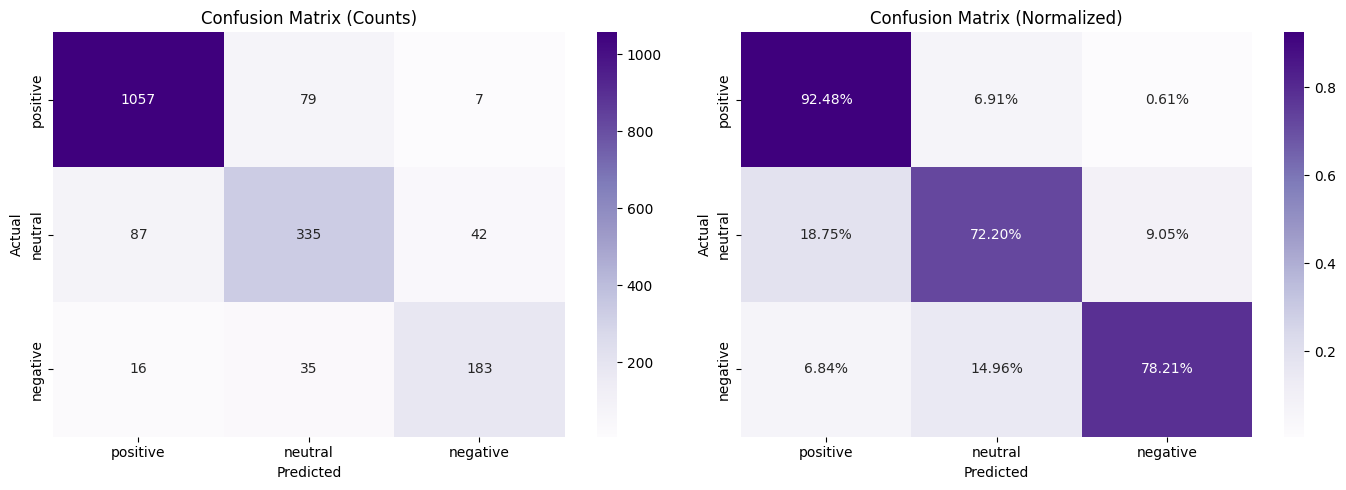

In [10]:
## 9. Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=target_names, yticklabels=target_names, ax=axes[0])
axes[0].set_title('Confusion Matrix (Counts)')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='Purples',
            xticklabels=target_names, yticklabels=target_names, ax=axes[1])
axes[1].set_title('Confusion Matrix (Normalized)')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()


=== MODEL COMPARISON ===
                         Model  Accuracy (%)                                   Features  Training Data
SVM (RBF) + Embeddings + VADER          79.7 sentence_embeddings(384) + vader_scaled(4)          27438
         DistilBERT Fine-tuned          85.6              End-to-end (raw text → label)          14726


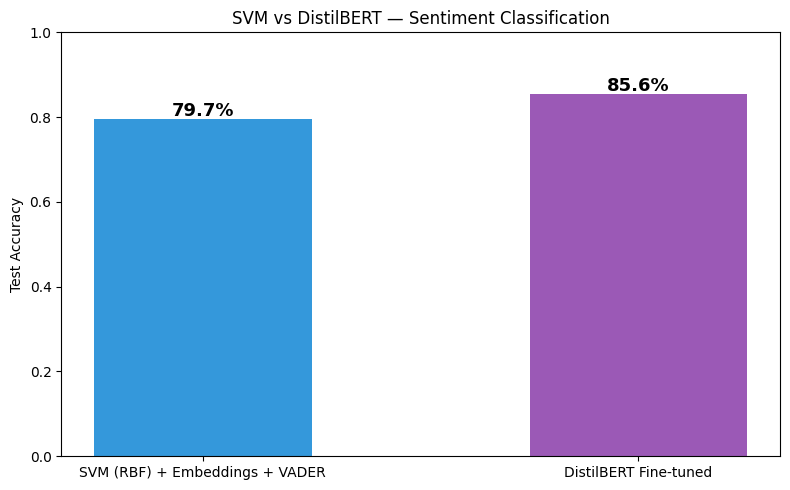

In [11]:
## 10. Compare with SVM Baseline
svm_info_path = '/home/ram/sentiment_mlops/models/svm_model_info.json'
if os.path.exists(svm_info_path):
    with open(svm_info_path) as f:
        svm_info = json.load(f)
    
    comparison = pd.DataFrame({
        'Model': ['SVM (RBF) + Embeddings + VADER', 'DistilBERT Fine-tuned'],
        'Test Accuracy': [svm_info['accuracy'], acc],
        'Features': [svm_info['features'], 'End-to-end (raw text → label)'],
        'Training Data': [svm_info['train_samples'], len(train_ds)],
    })
    comparison['Accuracy (%)'] = (comparison['Test Accuracy'] * 100).round(1)
    print('\n=== MODEL COMPARISON ===')
    print(comparison[['Model', 'Accuracy (%)', 'Features', 'Training Data']].to_string(index=False))
    
    # Bar chart
    fig, ax = plt.subplots(figsize=(8, 5))
    bars = ax.bar(comparison['Model'], comparison['Test Accuracy'],
                  color=['#3498db', '#9b59b6'], width=0.5)
    for bar, val in zip(bars, comparison['Test Accuracy']):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                f'{val:.1%}', ha='center', fontsize=13, fontweight='bold')
    ax.set_ylabel('Test Accuracy')
    ax.set_title('SVM vs DistilBERT — Sentiment Classification')
    ax.set_ylim(0, 1)
    plt.tight_layout()
    plt.show()
else:
    print(f'SVM model info not found at {svm_info_path}')
    print(f'DistilBERT Test Accuracy: {acc:.4f} ({acc*100:.1f}%)')

In [12]:
## 11. Save Model & Tokenizer for Deployment
trainer.save_model(MODEL_PATH)
tokenizer.save_pretrained(MODEL_PATH)

# Save model performance metadata
model_info = {
    'model': 'DistilBERT fine-tuned (3-class)',
    'base_model': MODEL_NAME,
    'accuracy': float(acc),
    'num_labels': 3,
    'label_map': label_map,
    'max_length': MAX_LENGTH,
    'epochs': int(training_args.num_train_epochs),
    'train_samples': len(train_ds),
    'test_samples': len(test_ds)
}
with open(os.path.join(MODEL_PATH, 'model_info.json'), 'w') as f:
    json.dump(model_info, f, indent=2)

print(f'Saved to: {MODEL_PATH}')
print(f'Contents:')
for f_name in sorted(os.listdir(MODEL_PATH)):
    size = os.path.getsize(os.path.join(MODEL_PATH, f_name))
    print(f'  {f_name:40s} {size/1024/1024:.1f} MB' if size > 1024*1024 else f'  {f_name:40s} {size/1024:.1f} KB')

Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]

Saved to: /home/ram/sentiment_mlops/models/distilbert_sentiment/
Contents:
  checkpoint-1383                          4.0 KB
  checkpoint-461                           4.0 KB
  checkpoint-922                           4.0 KB
  config.json                              0.8 KB
  model.safetensors                        255.4 MB
  model_info.json                          0.3 KB
  tokenizer.json                           695.0 KB
  tokenizer_config.json                    0.3 KB
  training_args.bin                        5.1 KB


In [13]:
## 12. Quick Test — Predict on Sample Comments
from transformers import pipeline

# Load as a pipeline for easy inference
classifier = pipeline(
    'text-classification',
    model=MODEL_PATH,
    tokenizer=MODEL_PATH,
    device=0 if device == 'cuda' else -1,
    top_k=None  # Return all class probabilities
)

test_comments = [
    "This video is absolutely amazing! Best tutorial ever!",
    "Terrible content, waste of my time.",
    "The video is 10 minutes long.",
    "I love how you explained the concept so clearly, subscribed!",
    "Boring and poorly made, dislike.",
    "Can someone tell me the timestamp for the second part?"
]

results = []
for comment in test_comments:
    preds = classifier(comment)[0]  # list of {label, score}
    best = max(preds, key=lambda x: x['score'])
    results.append({
        'text': comment[:80],
        'prediction': best['label'],
        'confidence': f"{best['score']:.1%}"
    })

pd.DataFrame(results)

Loading weights: 100%|██████████| 104/104 [00:00<00:00, 323.94it/s, Materializing param=pre_classifier.weight]                                  


,text,prediction,confidence
0,This video is absolutely amazing! Best tutoria...,positive,99.6%
1,"Terrible content, waste of my time.",negative,98.1%
2,The video is 10 minutes long.,neutral,51.7%
3,I love how you explained the concept so clearl...,positive,99.7%
4,"Boring and poorly made, dislike.",negative,97.9%
5,Can someone tell me the timestamp for the seco...,neutral,96.2%
